# Choosing the Right Location for a Film Festival in London
### Applied Data Science Capstone by IBM/Coursera: Final Assignment

**Table of contents:**
1. [Introduction](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Results and discussion](#results)
5. [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

A worldwide-known Italian foundation specialized in film conservation and restoration organizes a popular film festival every summer in the small town of Bologna, Italy, in which they present the latest film restorations from all over the world. The festival is now so popular that they are considering exporting it to another country: this way, the films could be presented a second time, on the international stage, and have more resonance.

More specifically, they wish to:
1. Export the festival to a renowned, **cosmopolitan city** where the films can be shown in **English** or with English subtitles;
2. Find **three cinemas** close together, at a distance that can be covered quickly, possibly on foot, because the festival is made up of three parallel screenings programs running simultaneously and the guests may want to switch during the day. The three cinemas should preferably be **independently owned**, as independent venues tend to have more character, or at least venues of historical interest;
3. Choose a location equipped with enough **hotels, restaurants and amenities** to accommodate and entertain the large number of guests who faithfully attend the festival every year.

Based on their requests, in this project I will suggest that they choose **London** as their location.

## Data <a name="data"></a>

London may appear like quite an intimidating giant to approach. Fortunately, however, London is divided into boroughs: smaller units of government, or councils, keen to promote themselves by hosting events on their territory. So, if the foundation was to organize the festival in London, as I think they should, I would suggest that they deal with the local borough councils directly. For this reason, the research will treat the borough as the referent of choice and consider only cinemas within the same borough. The boroughs that satisfy the requirements and are closer to the center will be considered first, except for the City of Westminster, which I am going to consider as a last resort because it is already too saturated with theater and cinema events.

### Data Sources

The starting point of the research is a table of location data extracted from the **Wikipedia** website. From this table, after a proper amount of data cleaning, I will derive the coordinates needed to query the **Foursquare** database. The Foursquare database will be crucial to obtaining a list of the cinemas in London divided by borough and to highlighting the most promising locations in terms of food, entertainment and accommodation. 
<br>
<br>
First of all, I will proceed to import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import requests
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium=0.5.0 --yes
import folium
!pip install lxml
import lxml
print('Libraries imported!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

### Data cleaning

The starting point of the research is the following table, which contains the location data of each London borough, scraped from Wikipedia.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
London_Data = requests.get(url)

Borough_df = pd.read_html(London_Data.content, header=0)[0]
Borough_df.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


I will now proceed to eliminate the columns which are irrelevant to the research. I am going to keep the Area and Population columns because they may turn out to be useful later on, perhaps to get to know a certain borough a little better.

In [3]:
Borough_df.drop(columns=['Inner','Status','Local authority','Political control','Headquarters','Nr. in map'], inplace=True)
Borough_df.rename(columns={'Population (2013 est)[1]':'Population'}, inplace=True)
Borough_df

,Borough,Area (sq mi),Population,Co-ordinates
0,Barking and Dagenham [note 1],13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E
1,Barnet,33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W
2,Bexley,23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E
3,Brent,16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W
4,Bromley,57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E
5,Camden,8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W
6,Croydon,33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W
7,Ealing,21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W
8,Enfield,31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W
9,Greenwich [note 2],18.28,264008,51°29′21″N 0°03′53″E﻿ / ﻿51.4892°N 0.0648°E


As you can see, the coordinates are presented in two different formats, DMS and decimal: I am going to choose the second format, as I can more easily strip it of unnecessary characters.

In [4]:
Borough_df['Coordinates'] = Borough_df['Co-ordinates'].str.split('/').str[1]
Borough_df.drop(columns=['Co-ordinates'], inplace=True)
Borough_df.head()

,Borough,Area (sq mi),Population,Coordinates
0,Barking and Dagenham [note 1],13.93,194352,﻿51.5607°N 0.1557°E
1,Barnet,33.49,369088,﻿51.6252°N 0.1517°W
2,Bexley,23.38,236687,﻿51.4549°N 0.1505°E
3,Brent,16.70,317264,﻿51.5588°N 0.2817°W
4,Bromley,57.97,317899,﻿51.4039°N 0.0198°E


I am now going to split the Coordinates column into two columns: Latitude and Longitude.

In [5]:
Borough_df[['Latitude','Longitude']] = Borough_df['Coordinates'].str.split("°N ",expand=True)
Borough_df.drop(columns=['Coordinates'], inplace=True)
Borough_df.head()

,Borough,Area (sq mi),Population,Latitude,Longitude
0,Barking and Dagenham [note 1],13.93,194352,﻿51.5607,0.1557°E
1,Barnet,33.49,369088,﻿51.6252,0.1517°W
2,Bexley,23.38,236687,﻿51.4549,0.1505°E
3,Brent,16.70,317264,﻿51.5588,0.2817°W
4,Bromley,57.97,317899,﻿51.4039,0.0198°E


Now I can finally strip the coordinates of unnecessary characters, such as 'N', 'E', 'W', '°' and '/'. This is a necessary step, otherwise I will not be able to plot them on a map or use them to query the Foursquare database.

In [6]:
Borough_df['Latitude'] =Borough_df['Latitude'].map(lambda x: x.rstrip('°N'))
Borough_df['Longitude'] =Borough_df['Longitude'].map(lambda x: x.rstrip('°E°W'))
Borough_df['Longitude'] = '-' + Borough_df['Longitude']
Borough_df.head()

,Borough,Area (sq mi),Population,Latitude,Longitude
0,Barking and Dagenham [note 1],13.93,194352,﻿51.5607,-0.1557
1,Barnet,33.49,369088,﻿51.6252,-0.1517
2,Bexley,23.38,236687,﻿51.4549,-0.1505
3,Brent,16.70,317264,﻿51.5588,-0.2817
4,Bromley,57.97,317899,﻿51.4039,-0.0198


Now, let's tidy up the Borough column by getting rid of unnecessary extra words.

In [7]:
Borough_df.iloc[0,0] = 'Barking and Dagenham'
Borough_df.iloc[9,0] = 'Greenwich'
Borough_df.iloc[11,0] = 'Hammersmith and Fulham'
Borough_df.head(15)

,Borough,Area (sq mi),Population,Latitude,Longitude
0,Barking and Dagenham,13.93,194352,﻿51.5607,-0.1557
1,Barnet,33.49,369088,﻿51.6252,-0.1517
2,Bexley,23.38,236687,﻿51.4549,-0.1505
3,Brent,16.70,317264,﻿51.5588,-0.2817
4,Bromley,57.97,317899,﻿51.4039,-0.0198
5,Camden,8.40,229719,﻿51.5290,-0.1255
6,Croydon,33.41,372752,﻿51.3714,-0.0977
7,Ealing,21.44,342494,﻿51.5130,-0.3089
8,Enfield,31.74,320524,﻿51.6538,-0.0799
9,Greenwich,18.28,264008,﻿51.4892,-0.0648


Now that I look at the coordinates, I see that something is not right. Isn't Greenwich supposed to be the Prime Meridian? Shouldn't its Longitude be closer to zero? As I double-check the coordinates on Google Maps one by one, I realize that there are mistakes all along the line. It would all be much simpler if I could get a Google Maps API, but they started charging for it. I spare you the attempt I made to get a new set of coordinates through Geopy's geocoding service, because I encountered quite a few mistakes there too, and I will just proceed to adding a new set of Latitude coordinates manually. The source of the new, definitive set is, as you may expect, Google Maps.

In [8]:
Latitude_df=[51.5366,51.6569,51.4549,51.5588,51.4039,51.5290,51.3714,51.5130,51.6538,51.4934,51.5450,51.4912,51.6000,51.5898,51.5812,51.5441,51.4746,51.5416,51.4991,51.4085,51.4607,51.4452,51.4014,51.5077,51.5590,51.4479,51.5035,51.3618,51.5099,51.5908,51.4567,51.4975]
Borough_df['Latitude']=Latitude_df
Borough_df

,Borough,Area (sq mi),Population,Latitude,Longitude
0,Barking and Dagenham,13.93,194352,51.5366,-0.1557
1,Barnet,33.49,369088,51.6569,-0.1517
2,Bexley,23.38,236687,51.4549,-0.1505
3,Brent,16.70,317264,51.5588,-0.2817
4,Bromley,57.97,317899,51.4039,-0.0198
5,Camden,8.40,229719,51.5290,-0.1255
6,Croydon,33.41,372752,51.3714,-0.0977
7,Ealing,21.44,342494,51.5130,-0.3089
8,Enfield,31.74,320524,51.6538,-0.0799
9,Greenwich,18.28,264008,51.4934,-0.0648


Let's not forget Greenwich's Longitude which is, as I suspected, much closer to zero.

In [9]:
Borough_df['Longitude'].replace({'-0.0648':'-0.0098'}, inplace=True)
Borough_df

,Borough,Area (sq mi),Population,Latitude,Longitude
0,Barking and Dagenham,13.93,194352,51.5366,-0.1557
1,Barnet,33.49,369088,51.6569,-0.1517
2,Bexley,23.38,236687,51.4549,-0.1505
3,Brent,16.70,317264,51.5588,-0.2817
4,Bromley,57.97,317899,51.4039,-0.0198
5,Camden,8.40,229719,51.5290,-0.1255
6,Croydon,33.41,372752,51.3714,-0.0977
7,Ealing,21.44,342494,51.5130,-0.3089
8,Enfield,31.74,320524,51.6538,-0.0799
9,Greenwich,18.28,264008,51.4934,-0.0098


Lastly, I will convert the Longitude column values into floats.

In [10]:
print (Borough_df.dtypes)

Borough          object
Area (sq mi)    float64
Population        int64
Latitude        float64
Longitude        object
dtype: object


In [11]:
Borough_df['Longitude'] = pd.to_numeric(Borough_df['Longitude'])
print (Borough_df.dtypes)

Borough          object
Area (sq mi)    float64
Population        int64
Latitude        float64
Longitude       float64
dtype: object


I will now use Geocoder to establish London's coordinates and I will verify that the boroughs are finally correctly placed by plotting them on a Folium map.

In [12]:
geolocator = Nominatim(user_agent="london_explorer")
address = 'London, UK'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of London, UK are {}, {}.'.format(latitude, longitude))

The geographical coordinates of London, UK are 51.5073219, -0.1276474.


In [13]:
london_map = folium.Map(location=[latitude, longitude], zoom_start=11)
#Borough_map= folium.map.FeatureGroup()
for lat, lng, borough, area in zip(Borough_df['Latitude'], Borough_df['Longitude'],Borough_df['Borough'],Borough_df['Area (sq mi)']):
    label = '{}, {}'.format(borough,area)
    label = folium.Popup(label, parse_html=True)
    #Borough_map.add_child(
    folium.CircleMarker(
            [lat, lng],
            radius=20,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(london_map)
     
london_map
#.add_child(Borough_map)

### Foursquare

Now that the spatial coordinates make sense and everything seems to be in order, I can move on to querying the Foursquare database. Since I want to look only for cinemas, I will use the corresponding category ID ('Movie Theater') to narrow the search.

In [14]:
CLIENT_ID = '3HENYGD1LS2HOGU2SILPUQGQDZ43GWO1CKLPI12GISJH25QH'
CLIENT_SECRET = 'ZRNQMMRPXBLLMCJXTKEQI02K31CB5S4XWS4ORKAHIHUQMBJC'
VERSION = '20200508'
categoryId='4bf58dd8d48988d17f941735'
intent='browse'
radius=8000
LIMIT=100     

In [15]:
url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&intent={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, intent, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=3HENYGD1LS2HOGU2SILPUQGQDZ43GWO1CKLPI12GISJH25QH&client_secret=ZRNQMMRPXBLLMCJXTKEQI02K31CB5S4XWS4ORKAHIHUQMBJC&ll=51.5073219,-0.1276474&v=20200508&categoryId=4bf58dd8d48988d17f941735&intent=browse&radius=8000&limit=100'

In [16]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ecab7429388d7001bda8226'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'London',
  'headerFullLocation': 'London',
  'headerLocationGranularity': 'city',
  'query': 'movie theater',
  'totalResults': 99,
  'suggestedBounds': {'ne': {'lat': 51.57932197200007,
    'lng': -0.012184753085708475},
   'sw': {'lat': 51.43532182799993, 'lng': -0.2431100469142915}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad09ceff964a520bdd820e3',
       'name': 'Prince Charles Cinema',
       'location': {'address': '7 Leicester Pl',
        'lat': 51.511528990521576,
        'lng': -0.13026895620875775,
        'labeledLatLngs': [{'label': 'display',
     

Foursquare returned a gigantic list, as expected, which I am going to have to clean up. To be able to do that, I need to turn the results into a dataframe: cinemas_df.

In [17]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
venues = results['response']['groups'][0]['items']

cinemas_df= json_normalize(venues)
cinemas_df.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.events.count,venue.events.summary,venue.id,venue.location.address,venue.location.cc,venue.location.city,...,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad09ceff964a520bdd820e3-0,"[{'id': '4bf58dd8d48988d17e941735', 'name': 'I...",23.0,23 movies,4ad09ceff964a520bdd820e3,7 Leicester Pl,GB,London,...,"[{'label': 'display', 'lat': 51.51152899052157...",51.511529,-0.130269,NaN,WC2H 7BY,Greater London,Prince Charles Cinema,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-557f12cf498e2f025de8c7d0-1,"[{'id': '4bf58dd8d48988d180941735', 'name': 'M...",NaN,NaN,557f12cf498e2f025de8c7d0,Shaftesbury Ave,GB,Soho,...,"[{'label': 'display', 'lat': 51.51069477131599...",51.510695,-0.133956,NaN,W1D 7DH,Greater London,Picturehouse Central,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4e9874f077c8d1cccbbb5b89-2,"[{'id': '4bf58dd8d48988d17e941735', 'name': 'I...",NaN,NaN,4e9874f077c8d1cccbbb5b89,ICA,GB,London,...,"[{'label': 'display', 'lat': 51.50601829812378...",51.506018,-0.131068,City of Westminster,NaN,Greater London,ICA Cinema,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-57f6ab10498edae0d8f7b521-3,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",NaN,NaN,57f6ab10498edae0d8f7b521,Embankment Gardens,GB,London,...,"[{'label': 'display', 'lat': 51.50804334162284...",51.508043,-0.122221,NaN,WC2N 6NS,Greater London,Embankment Garden Cinema,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4aeca7bbf964a520f8c921e3-4,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",NaN,NaN,4aeca7bbf964a520f8c921e3,99 Shaftesbury Av,GB,London,...,"[{'label': 'display', 'lat': 51.51260854390062...",51.512609,-0.130520,NaN,W1D 5DY,Greater London,Curzon Soho,0,[],NaN


Looking at the above sample of the data frame, I can see that in most cases Foursquare does not specify in which neighborhood or borough the cinemas are. As a consequence, I am going to have to rely on the coordinates alone to assign cinemas to the closest borough.<br>
Let's first proceed to filter the columns.

In [19]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
cinemas_df = cinemas_df.loc[:, filtered_columns]
    
cinemas_df['venue.categories'] = cinemas_df.apply(get_category_type, axis=1)
cinemas_df.columns = [col.split('.')[-1] for col in cinemas_df.columns]
cinemas_df.head()    

,name,categories,lat,lng
0,Prince Charles Cinema,Indie Movie Theater,51.511529,-0.130269
1,Picturehouse Central,Multiplex,51.510695,-0.133956
2,ICA Cinema,Indie Movie Theater,51.506018,-0.131068
3,Embankment Garden Cinema,Movie Theater,51.508043,-0.122221
4,Curzon Soho,Movie Theater,51.512609,-0.130520


And let's look at the shape of the data frame cinemas_df:

In [20]:
print(cinemas_df.shape)

(99, 4)


Now, I am going to define a function to assign each cinema in the list retrieved by Foursquare to the closest borough, based on the coordinates defined in the original data frame: Borough_df.

In [21]:
def getLocalCinemas (names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4bf58dd8d48988d17f941735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']) for v in results])

    cinemas_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    cinemas_df.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                'Venue Distance',
                  'Venue Category']
    
    return(cinemas_df)

Let's now call the function and create a new data frame (London_cinemas) which merges Borough_df with cinemas_df:

In [22]:
London_cinemas=getLocalCinemas(names=Borough_df['Borough'],
                               latitudes=Borough_df['Latitude'],
                               longitudes=Borough_df['Longitude'],
                               )
print(London_cinemas.shape)

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster
(162, 8)


Let's now have a look at the new data frame London_cinemas:

In [23]:
London_cinemas.head(30)

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,Barking and Dagenham,51.5366,-0.1557,Madame Tussauds 4D,51.522817,-0.154881,1535,Movie Theater
1,Barking and Dagenham,51.5366,-0.1557,Everyman Cinema,51.550708,-0.166041,1725,Movie Theater
2,Barking and Dagenham,51.5366,-0.1557,Everyman Cinema,51.520437,-0.156609,1800,Movie Theater
3,Barking and Dagenham,51.5366,-0.1557,Odeon,51.542510,-0.174568,1462,Movie Theater
4,Barking and Dagenham,51.5366,-0.1557,Odeon,51.538837,-0.143529,878,Movie Theater
5,Bexley,51.4549,-0.1505,Clapham Picturehouse,51.462510,-0.137996,1212,Movie Theater
6,Bexley,51.4549,-0.1505,Movie1,51.445773,-0.150483,1016,Movie Theater
7,Brent,51.5588,-0.2817,Cineworld,51.556873,-0.283228,239,Multiplex
8,Brent,51.5588,-0.2817,The Odean,51.556397,-0.303065,1502,Multiplex
9,Bromley,51.4039,-0.0198,Odeon,51.407131,-0.031209,870,Movie Theater


At a first glance, the result seems rather satisfactory. I don't see many mistakes in the pairings of cinemas and boroughs, except in Camden's case. The borough of Camden and the City of Westminster are neighbors and many of Westminster's cinemas are close to the 'border' with Camden, so they have been mistakenly assigned to Camden instead.

I will fix the Camden issue. But first, let's drop eventual duplicates:

In [24]:
London_cinemas.drop_duplicates(subset='Venue',inplace=True)
London_cinemas.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,Barking and Dagenham,51.5366,-0.1557,Madame Tussauds 4D,51.522817,-0.154881,1535,Movie Theater
1,Barking and Dagenham,51.5366,-0.1557,Everyman Cinema,51.550708,-0.166041,1725,Movie Theater
3,Barking and Dagenham,51.5366,-0.1557,Odeon,51.542510,-0.174568,1462,Movie Theater
5,Bexley,51.4549,-0.1505,Clapham Picturehouse,51.462510,-0.137996,1212,Movie Theater
6,Bexley,51.4549,-0.1505,Movie1,51.445773,-0.150483,1016,Movie Theater


I now need to get rid of unnecessary categories. As I stated in the introduction, the foundation is interested in independent cinemas. Unfortunately, Foursquare does not distinguish between independent cinemas and cinemas chains, but it classifies multiplexes as a separate category. I have also noticed an 'Art Gallery' entry in the Venue Category column above. Before removing any category, I want to inspect the data frame for other unrelated categories that do not correspond to the original category ID I had chosen for the query ('Movie Theater'):

In [25]:
print(London_cinemas.loc[London_cinemas['Venue Category']!='Movie Theater'])

                    Borough  Borough Latitude  Borough Longitude  \
7                     Brent           51.5588            -0.2817   
8                     Brent           51.5588            -0.2817   
18                   Camden           51.5290            -0.1255   
23                   Camden           51.5290            -0.1255   
31                   Camden           51.5290            -0.1255   
36                   Camden           51.5290            -0.1255   
37                   Camden           51.5290            -0.1255   
38                   Camden           51.5290            -0.1255   
41                  Croydon           51.3714            -0.0977   
44                   Ealing           51.5130            -0.3089   
46                   Ealing           51.5130            -0.3089   
47                   Ealing           51.5130            -0.3089   
48                   Ealing           51.5130            -0.3089   
49                   Ealing           51.5130   

I can now safely say that I am only interested in two categories: 'Movie Theater' and 'Indie Movie Theater'. I am going to get rid of all others, because they are irrelevant to my research:

In [26]:
London_cinemas.drop(London_cinemas[(London_cinemas['Venue Category']!='Movie Theater')&(London_cinemas['Venue Category']!='Indie Movie Theater')].index, inplace=True)
London_cinemas.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,Barking and Dagenham,51.5366,-0.1557,Madame Tussauds 4D,51.522817,-0.154881,1535,Movie Theater
1,Barking and Dagenham,51.5366,-0.1557,Everyman Cinema,51.550708,-0.166041,1725,Movie Theater
3,Barking and Dagenham,51.5366,-0.1557,Odeon,51.542510,-0.174568,1462,Movie Theater
5,Bexley,51.4549,-0.1505,Clapham Picturehouse,51.462510,-0.137996,1212,Movie Theater
6,Bexley,51.4549,-0.1505,Movie1,51.445773,-0.150483,1016,Movie Theater


Let's now fix the problem with Camden, which 'stole' some of Westminster's cinemas.

In [27]:
London_cinemas[London_cinemas.Borough=='Camden']

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
10,Camden,51.529,-0.1255,Curzon Bloomsbury,51.524120,-0.123002,570,Movie Theater
12,Camden,51.529,-0.1255,Warner Bros Screening Rooms,51.520104,-0.118956,1089,Movie Theater
14,Camden,51.529,-0.1255,NBC Universal Screening Rooms,51.516105,-0.127104,1439,Movie Theater
16,Camden,51.529,-0.1255,Regent Street Cinema,51.516852,-0.142657,1800,Movie Theater
17,Camden,51.529,-0.1255,Soho Screening Rooms,51.514548,-0.136489,1779,Movie Theater
19,Camden,51.529,-0.1255,Dolby Screening Room,51.515472,-0.132822,1588,Movie Theater
20,Camden,51.529,-0.1255,Curzon Soho,51.512609,-0.130520,1857,Movie Theater
21,Camden,51.529,-0.1255,West End Film Club,51.512028,-0.132222,1945,Movie Theater
22,Camden,51.529,-0.1255,London Film Museum,51.512412,-0.121043,1872,Movie Theater
24,Camden,51.529,-0.1255,Rada Bar / Theatres,51.521988,-0.130920,866,Movie Theater


From the list above, I can gather that those cinemas which are further than 1500 meters away from the given Camden coordinates are in fact part of Westminster. In other words, those cinemas with a Venue Distance greater than 1500 don't actually belong in Camden. So I am going to assign them to the City of Westminster, where they belong:

In [28]:
London_cinemas.loc[(London_cinemas['Borough']=='Camden')&(London_cinemas['Venue Distance']>1500), 'Borough'] = 'Westminster'
London_cinemas[London_cinemas.Borough=='Camden']

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
10,Camden,51.529,-0.1255,Curzon Bloomsbury,51.524120,-0.123002,570,Movie Theater
12,Camden,51.529,-0.1255,Warner Bros Screening Rooms,51.520104,-0.118956,1089,Movie Theater
14,Camden,51.529,-0.1255,NBC Universal Screening Rooms,51.516105,-0.127104,1439,Movie Theater
24,Camden,51.529,-0.1255,Rada Bar / Theatres,51.521988,-0.130920,866,Movie Theater
25,Camden,51.529,-0.1255,Charlotte Street Hotel Screening Room,51.518454,-0.134541,1330,Movie Theater
37,Camden,51.529,-0.1255,Bertha DocHouse,51.523714,-0.122986,613,Indie Movie Theater


I am now going to have a look at the cinemas in the City of Westminster, to see if the new list, comprehensive of those cinemas which were previously assigned to Camden, now makes sense. And I think it does.

In [29]:
London_cinemas[London_cinemas.Borough=='Westminster']

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
16,Westminster,51.5290,-0.1255,Regent Street Cinema,51.516852,-0.142657,1800,Movie Theater
17,Westminster,51.5290,-0.1255,Soho Screening Rooms,51.514548,-0.136489,1779,Movie Theater
19,Westminster,51.5290,-0.1255,Dolby Screening Room,51.515472,-0.132822,1588,Movie Theater
20,Westminster,51.5290,-0.1255,Curzon Soho,51.512609,-0.130520,1857,Movie Theater
21,Westminster,51.5290,-0.1255,West End Film Club,51.512028,-0.132222,1945,Movie Theater
22,Westminster,51.5290,-0.1255,London Film Museum,51.512412,-0.121043,1872,Movie Theater
26,Westminster,51.5290,-0.1255,MPC (Moving Picture Company),51.513701,-0.134307,1809,Movie Theater
27,Westminster,51.5290,-0.1255,20th Century Fox screening room,51.514826,-0.132252,1645,Movie Theater
28,Westminster,51.5290,-0.1255,One7nine,51.515163,-0.135357,1684,Movie Theater
29,Westminster,51.5290,-0.1255,Soho Hotel Screening Rooms,51.514103,-0.133662,1752,Movie Theater


## Methodology <a name="methodology"></a>

### Exploratory Data Analysis

After data cleaning, we are now confronted with the following situation: as the bar chart below shows, the boroughs that possess the requirements for further exploration, i.e. a minimum of three cinemas within their jurisdiction, are not that many. Interestingly, there are many rather peripheral areas among them: Ealing, Havering, Lewisham, Richmond, Barking and Dagenham. As expected, the City of Westminster, with its array of West End cinemas, wins the contest by an overwhelming majority. This is not very good news, as I said that I was going to privilege the boroughs closest to the center and leave Westminster for last because there is too much competition. Furthermore, as we know, the three cinemas requisite is not enough: I have to establish how far apart the cinemas are, if they are independently owned or at least venues of character, and if the area around them can be appealing enough to the guests - so the already narrow list is going to be narrowed further.

In [30]:
cinemas_numeric=London_cinemas['Borough'].value_counts(ascending=False)
cinemas_numeric

Westminster               24
Ealing                     7
Camden                     6
Hackney                    5
Lewisham                   4
Lambeth                    4
Kensington and Chelsea     4
Havering                   4
Southwark                  3
Richmond upon Thames       3
Barking and Dagenham       3
Waltham Forest             2
Newham                     2
Bexley                     2
Hammersmith and Fulham     2
Greenwich                  2
Croydon                    2
Enfield                    1
Harrow                     1
Tower Hamlets              1
Merton                     1
Hounslow                   1
Hillingdon                 1
Name: Borough, dtype: int64

As I was saying, the bar chart shows that there are only eleven boroughs that we can proceed with. Of these, five are really far from the center and one is the City of Westminster.

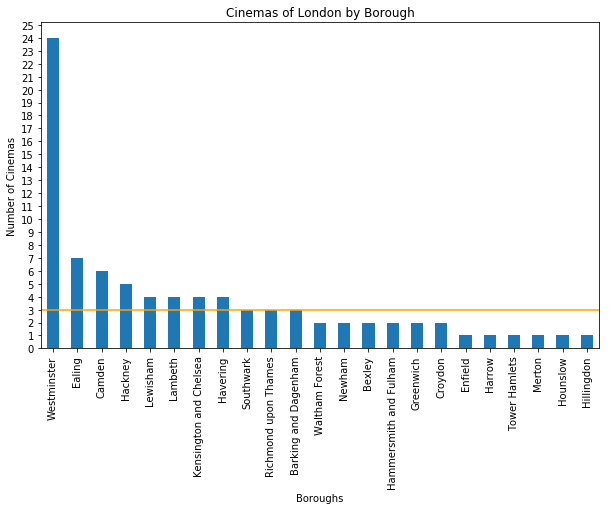

In [31]:
import matplotlib.pyplot as plt

cinemas_numeric.plot(kind='bar', figsize=(10, 6), yticks=range(0,26,1))
plt.title('Cinemas of London by Borough') 
plt.ylabel('Number of Cinemas') 
plt.xlabel('Boroughs')
plt.axhline(y=3, color='orange')

Since we are dealing with spatial data, I think it is important to visualize the cinemas (as blue circles) and their respective boroughs (as red dots) on a Folium Map.

In [32]:
cinemas_map=folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, venue, borough in zip(London_cinemas['Venue Latitude'], London_cinemas['Venue Longitude'], London_cinemas['Venue'], London_cinemas['Borough']):
    label = '{}, {}'.format(venue, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cinemas_map)  
for lat, lng, borough in zip(London_cinemas['Borough Latitude'], London_cinemas['Borough Longitude'], London_cinemas['Borough']):    
    folium.CircleMarker(
        [lat,lng],
        radius=2,
        popup=borough,
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(cinemas_map)
cinemas_map

The map shows that most cinemas are in the center of London, while most peripheral boroughs don't have enough cinemas to be taken into consideration. Another interesting point to make is that the cinemas in the boroughs of Ealing and Havering seem to mysteriously overlap. Something is not quite right there, but the map cannot tell us what it is. In fact, the map cannot help us any further in any way. To study the cinemas and their boroughs in more detail, I am going to turn the boroughs into clusters by using DBSCAN, as it is the most fitting algorithm when dealing with spatial data.

### Clustering the Boroughs

In [33]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler 
Cinema_clusters = London_cinemas[['Borough Latitude','Borough Longitude','Venue Latitude','Venue Longitude']]
Cinema_clusters = np.nan_to_num(Cinema_clusters)
Cinema_clusters = StandardScaler().fit_transform(Cinema_clusters)

# Compute DBSCAN
db = DBSCAN(eps=0.4, min_samples=3).fit(Cinema_clusters)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
London_cinemas["Clus_Labels"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

London_cinemas.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
0,Barking and Dagenham,51.5366,-0.1557,Madame Tussauds 4D,51.522817,-0.154881,1535,Movie Theater,-1
1,Barking and Dagenham,51.5366,-0.1557,Everyman Cinema,51.550708,-0.166041,1725,Movie Theater,-1
3,Barking and Dagenham,51.5366,-0.1557,Odeon,51.542510,-0.174568,1462,Movie Theater,-1
5,Bexley,51.4549,-0.1505,Clapham Picturehouse,51.462510,-0.137996,1212,Movie Theater,-1
6,Bexley,51.4549,-0.1505,Movie1,51.445773,-0.150483,1016,Movie Theater,-1


The algorithm returned 10 clusters, plus outliers, which I am now going to plot on a map.

In [34]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 9, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(London_cinemas['Borough Latitude'], London_cinemas['Borough Longitude'], London_cinemas['Borough'], London_cinemas['Clus_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters


### The Clusters

Let's now study each cluster in more detail:

**City of Westminster**, which I said I was going to leave for last, as a last resort: the cluster contains eleven entries, five of which consist of the British Film Institute’s multiple venues and screens, including the IMAX. The British Film Institute is a giant of film conservation and exhibition that we do not want to compete with. This, plus all the competition in West End, are two good reasons to keep away from Westminster.

In [36]:
London_cinemas.loc[London_cinemas['Clus_Labels'] == 9, London_cinemas.columns[[0] + list(range(3, London_cinemas.shape[1]))]]

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
131,Westminster,Curzon Victoria,51.497473,-0.136744,31,Movie Theater,9
132,Westminster,Curzon Mayfair,51.506555,-0.147893,1251,Movie Theater,9
133,Westminster,Embankment Garden Cinema,51.508043,-0.122221,1566,Movie Theater,9
135,Westminster,London Eye 4D Experience,51.503031,-0.119222,1389,Movie Theater,9
136,Westminster,ODEON BFI IMAX,51.504995,-0.113529,1840,Movie Theater,9
146,Westminster,Sainsbury Wing Theatre,51.508355,-0.129647,1316,Movie Theater,9
150,Westminster,ICA Cinema,51.506018,-0.131068,1039,Indie Movie Theater,9
152,Westminster,Archlight Cinemas,51.482471,-0.146985,1805,Movie Theater,9
159,Westminster,BFI Southbank,51.506539,-0.115030,1836,Indie Movie Theater,9
160,Westminster,BFI Mediatheque,51.506518,-0.114916,1841,Indie Movie Theater,9


**Borough of Southwark**: the cluster contains two beautiful independent cinemas, which are not enough to satisfy the foundation’s needs.

In [37]:
London_cinemas.loc[London_cinemas['Clus_Labels'] == 8, London_cinemas.columns[[0] + list(range(3, London_cinemas.shape[1]))]]

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
116,Southwark,Back Yard Cinema,51.498710,-0.098394,1356,Movie Theater,8
117,Southwark,Curzon Sea Containers,51.508214,-0.106784,1901,Movie Theater,8
118,Southwark,Kino Bermondsey,51.497590,-0.080896,658,Indie Movie Theater,8


**Borough of Richmond upon Thames**: the three cinemas in the cluster all belong to chains and Richmond, however beautiful, is quite far from the centre.

In [38]:
London_cinemas.loc[London_cinemas['Clus_Labels'] == 7, London_cinemas.columns[[0] + list(range(3, London_cinemas.shape[1]))]]

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
111,Richmond upon Thames,Curzon Richmond,51.459257,-0.307020,1825,Movie Theater,7
112,Richmond upon Thames,Odeon Studios,51.459463,-0.305457,1920,Movie Theater,7
114,Richmond upon Thames,Richmond Filmhouse,51.458734,-0.308127,1729,Movie Theater,7


**Borough of Lewisham**: from a quick Google search, I found out that the Cabin Cinema does not exist; the Bellingham Film Palace is a screening room for hire inside a pub; Brockley Jack is a film club and therefore no good to us. It's a shame, but perhaps Lewisham was a little too far anyway.

In [39]:
London_cinemas.loc[London_cinemas['Clus_Labels'] == 6, London_cinemas.columns[[0] + list(range(3, London_cinemas.shape[1]))]]

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
100,Lewisham,Catford Mews,51.446005,-0.020414,95,Movie Theater,6
101,Lewisham,Bellingham Film Palace,51.432967,-0.019843,1363,Movie Theater,6
102,Lewisham,Cabin Cinema,51.443994,-0.040495,1366,Movie Theater,6
103,Lewisham,Brockley Jack Film Club,51.454505,-0.037470,1547,Movie Theater,6


**Borough of Lambeth**’s cluster is a little disappointing. I don't know where they got these iDisappointment and Rejection entries from, but they are obviously not cinemas. The Ritzy is a beauty and an institution, but two cinemas are not enough.

In [40]:
London_cinemas.loc[London_cinemas['Clus_Labels'] == 5, London_cinemas.columns[[0] + list(range(3, London_cinemas.shape[1]))]]

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
96,Lambeth,iDisappointment,51.461628,-0.115099,132,Movie Theater,5
97,Lambeth,Rejection,51.460893,-0.115035,90,Movie Theater,5
98,Lambeth,Ritzy Cinema,51.461153,-0.115013,102,Indie Movie Theater,5
99,Lambeth,Whirled Studios & Cinema,51.465041,-0.101222,1151,Indie Movie Theater,5


**Borough of Kensington and Chelsea**: at last a borough that I can use! Not too far from the center, attractive, very well-known, and with three independent cinemas.

In [41]:
London_cinemas.loc[London_cinemas['Clus_Labels'] == 4, London_cinemas.columns[[0] + list(range(3, London_cinemas.shape[1]))]]

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
87,Kensington and Chelsea,Gate Picturehouse,51.508752,-0.197312,1089,Movie Theater,4
88,Kensington and Chelsea,Science Museum (IMAX),51.497165,-0.177893,1184,Movie Theater,4
89,Kensington and Chelsea,Electric Cinema,51.515597,-0.204822,1965,Movie Theater,4
92,Kensington and Chelsea,Ciné lumière,51.494551,-0.177263,1310,Indie Movie Theater,4


**Borough of Havering**: besides being a little too far away, the borough looked promising - except for those mysteriously overlapping circles on the map from a little while ago. They just did not convince me. It took me a couple of minutes on the internet to find out that three cinemas out of four in the cluster do not exist. Or, rather, they exist elsewhere and they have been erroneously placed in this borough by well-meaning Foursquare users.

In [42]:
London_cinemas.loc[London_cinemas['Clus_Labels'] == 3, London_cinemas.columns[[0] + list(range(3, London_cinemas.shape[1]))]]

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
72,Havering,The Phoenix Cinema,51.588592,-0.163929,1595,Movie Theater,3
73,Havering,The Rex,51.588369,-0.164460,1551,Indie Movie Theater,3
74,Havering,The Coliseum,51.588234,-0.164148,1562,Indie Movie Theater,3
75,Havering,Picturedrome,51.589005,-0.163795,1628,Indie Movie Theater,3


**Borough of Hackney** is another pleasant surprise, as the cluster contains three independent cinemas, plus a Picturehouse cinema. Picturehouse is a chain, but the Hackney venue has a beautiful screening room in the attic (the Hackney Attic entry refers to this screening room). This is an appealing feature that is worth considering.

In [43]:
London_cinemas.loc[London_cinemas['Clus_Labels'] == 2, London_cinemas.columns[[0] + list(range(3, London_cinemas.shape[1]))]]

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
58,Hackney,Hackney Picturehouse,51.544841,-0.055399,18,Movie Theater,2
59,Hackney,Hackney Attic,51.544842,-0.055355,17,Movie Theater,2
60,Hackney,Arcola Theatre,51.546894,-0.074952,1376,Movie Theater,2
61,Hackney,Rio Cinema,51.549649,-0.075339,1480,Movie Theater,2
62,Hackney,The Castle Cinema,51.551238,-0.043369,1079,Indie Movie Theater,2


**Borough of Ealing** appears to contain seven entries, but in fact doesn't. Four entries out of seven correspond to the Rooftop cinema, which appears with four slightly different names in the Foursquare database. The mystery of the overlapping circles on the map is finally unveiled. The rooftop cinema, as the name suggests, it is an open-air cinema, which is a little risky considering London’s unpredictable weather. In addition to this, two of the remaining three entries are not cinemas, but film clubs, which are of no use to us.

In [44]:
London_cinemas.loc[London_cinemas['Clus_Labels'] == 1, London_cinemas.columns[[0] + list(range(3, London_cinemas.shape[1]))]]

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
42,Ealing,Ealing Town Hall / Classic Cinema Club,51.513000,-0.307710,82,Movie Theater,1
43,Ealing,Springbridge Rooftop Cinema,51.513986,-0.305058,287,Movie Theater,1
45,Ealing,The Edit Suite,51.529746,-0.302342,1918,Movie Theater,1
46,Ealing,rooftoo cinema ealing,51.514439,-0.306038,254,Indie Movie Theater,1
47,Ealing,Rooftop Cinema Ealing,51.514393,-0.305973,255,Indie Movie Theater,1
48,Ealing,Rooftop Cinema Club,51.514439,-0.306014,256,Indie Movie Theater,1
49,Ealing,The Cabbage Club,51.506729,-0.290825,1433,Indie Movie Theater,1


**Borough of Camden**: it contains lots of entries, which sounds promising, but thirteen of them actually belong in the City of Westminster. It is the usual misunderstanding, but it is of no consequence to us: Camden is definitely not our location. Out of the remaining six entries, only one is a cinema and it belongs to the Curzon cinema chain. Bertha Dochouse is an association based in that same Curzon cinema. The others are private screening rooms for hire and other categories of no interest for the purpose of this research.

In [45]:
London_cinemas.loc[London_cinemas['Clus_Labels'] == 0, London_cinemas.columns[[0] + list(range(3, London_cinemas.shape[1]))]]

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
10,Camden,Curzon Bloomsbury,51.524120,-0.123002,570,Movie Theater,0
12,Camden,Warner Bros Screening Rooms,51.520104,-0.118956,1089,Movie Theater,0
14,Camden,NBC Universal Screening Rooms,51.516105,-0.127104,1439,Movie Theater,0
16,Westminster,Regent Street Cinema,51.516852,-0.142657,1800,Movie Theater,0
17,Westminster,Soho Screening Rooms,51.514548,-0.136489,1779,Movie Theater,0
19,Westminster,Dolby Screening Room,51.515472,-0.132822,1588,Movie Theater,0
20,Westminster,Curzon Soho,51.512609,-0.130520,1857,Movie Theater,0
21,Westminster,West End Film Club,51.512028,-0.132222,1945,Movie Theater,0
22,Westminster,London Film Museum,51.512412,-0.121043,1872,Movie Theater,0
24,Camden,Rada Bar / Theatres,51.521988,-0.130920,866,Movie Theater,0


The rest are outliers and low density areas of two cinemas or less. DBSCAN kindly got rid of them for us.

In [46]:
London_cinemas.loc[London_cinemas['Clus_Labels'] == -1, London_cinemas.columns[[0] + list(range(3, London_cinemas.shape[1]))]]

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
0,Barking and Dagenham,Madame Tussauds 4D,51.522817,-0.154881,1535,Movie Theater,-1
1,Barking and Dagenham,Everyman Cinema,51.550708,-0.166041,1725,Movie Theater,-1
3,Barking and Dagenham,Odeon,51.542510,-0.174568,1462,Movie Theater,-1
5,Bexley,Clapham Picturehouse,51.462510,-0.137996,1212,Movie Theater,-1
6,Bexley,Movie1,51.445773,-0.150483,1016,Movie Theater,-1
39,Croydon,Gotham General Hospital,51.375573,-0.100091,493,Movie Theater,-1
41,Croydon,David Lean Cinema,51.372817,-0.098430,165,Indie Movie Theater,-1
51,Enfield,Magnet,51.646850,-0.060194,1565,Indie Movie Theater,-1
53,Greenwich,Sky Superscreen,51.503082,0.004736,1475,Movie Theater,-1
57,Greenwich,Greenwich Picturehouse,51.479619,-0.009778,1534,Indie Movie Theater,-1


### Examining the Finalists with Foursquare (again)

It seems to me that the borough of Kensington and Chelsea and the borough of Hackney just made the grade. Before I proceed to explore the neighborhoods, however, I am curious to see if the cinemas in both boroughs enjoy a good reputation among Foursquare users. 

#### Examining the Cinemas: Kensington and Chelsea

I am going to start by querying the database for the **Gate Picturehouse**'s average rating:

In [47]:
venue_id = '4ac518e8f964a52080ab20e3' # gate picturehouse
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url

'https://api.foursquare.com/v2/venues/4ac518e8f964a52080ab20e3?client_id=3HENYGD1LS2HOGU2SILPUQGQDZ43GWO1CKLPI12GISJH25QH&client_secret=ZRNQMMRPXBLLMCJXTKEQI02K31CB5S4XWS4ORKAHIHUQMBJC&v=20200508'

In [48]:
result = requests.get(url).json()
print(result['response']['venue'].keys())
result['response']['venue']

dict_keys(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories', 'verified', 'stats', 'url', 'likes', 'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'venuePage', 'reasons', 'description', 'storeId', 'page', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone', 'listed', 'popular', 'seasonalHours', 'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors'])


{'id': '4ac518e8f964a52080ab20e3',
 'name': 'Gate Picturehouse',
 'contact': {'phone': '+448719025731',
  'formattedPhone': '+44 871 902 5731',
  'twitter': 'gatecinema'},
 'location': {'address': '87 Notting Hill Gate',
  'lat': 51.508752326045226,
  'lng': -0.19731180190973402,
  'labeledLatLngs': [{'label': 'display',
    'lat': 51.508752326045226,
    'lng': -0.19731180190973402}],
  'postalCode': 'W11 3JZ',
  'cc': 'GB',
  'city': 'London',
  'state': 'Greater London',
  'country': 'United Kingdom',
  'formattedAddress': ['87 Notting Hill Gate',
   'London',
   'Greater London',
   'W11 3JZ',
   'United Kingdom']},
 'canonicalUrl': 'https://foursquare.com/v/gate-picturehouse/4ac518e8f964a52080ab20e3',
 'categories': [{'id': '4bf58dd8d48988d17f941735',
   'name': 'Movie Theater',
   'pluralName': 'Movie Theaters',
   'shortName': 'Movie Theater',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/movietheater_',
    'suffix': '.png'},
   'primary': Tru

In [49]:
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

8.4


"Lots of people love it", "it's 101 years old": it sounds great. And it has a very good average score of 8.4. Let's now move on to the **Electric Cinema**:

In [50]:
venue_id = '4ac518e8f964a520b0ab20e3' #       'name': 'Electric Cinema',
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

9.2


The Electric Cinema tops it with a 9.2! Finally, let's look at the third cinema in the borough: **Ciné Lumière**.

In [51]:
venue_id = '4ac518e8f964a5208fab20e3' #    'name': 'Ciné lumière'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

8.6


#### Examining the Cinemas: Hackney

The cinemas in Kensington and Chelsea have pleasantly surprised me. I hope that Hackney's will do the same.<br>
I will start with the **Rio Cinema**.

In [52]:
venue_id = '4ac518e8f964a520a6ab20e3'      #   'name': 'Rio Cinema'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

8.1


Then the **Arcola Theatre**:

In [53]:
venue_id = '4d28f2296e27a143b5951f24'     # 'name': 'Arcola Theatre',
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

9.0


That's very impressive. And now The **Castle Cinema**:

In [54]:
venue_id = '57e6ecb738fa7204f0b558c0'      # 'name': 'The Castle Cinema',
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

9.2


The Castle Cinema and The Electric Cinema have the highest average score so far. Finally, let's look at the **Hackney Picturehouse**:

In [55]:
venue_id = '4dc91970b0fbf26798c2c42c'       #name': 'Hackney Picturehouse'
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

9.0


Hackney's cinemas have even higher scores than Kensington's!<br>
I am now going to query the Foursquare database to get a couple of users' tips about the two cinemas that have impressed me the most: **The Electric Cinema** and **The Castle Cinema** respectively.

In [56]:
venue_id = '4ac518e8f964a520b0ab20e3' #electriccinema
limit = 15 
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ecab6ab211536001bd24929'},
 'response': {'tips': {'count': 66,
   'items': [{'id': '58deff0ed4390747e86f986f',
     'createdAt': 1491009294,
     'text': 'Super luxe cinema with large comfy leather seats, footstools, a cashmere blankets. Amazing snacks and drinks. Book in advance, as most showings sell out.',
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/58deff0ed4390747e86f986f',
     'lang': 'en',
     'likes': {'count': 0, 'groups': []},
     'logView': True,
     'agreeCount': 4,
     'disagreeCount': 0,
     'todo': {'count': 0},
     'user': {'id': '61949',
      'firstName': 'Ashleigh',
      'lastName': 'G',
      'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
       'suffix': '/61949_HP9XKy9V_ojX0w21Pp_miaiLevs162zFaTkcbPCOzRklgZeCXQn0gy4d_jyu6jsbXDRXqgz89.jpg'}},
     'authorInteractionType': 'liked'}]}}}

In [57]:
venue_id = '57e6ecb738fa7204f0b558c0' #thecastlecinema
limit = 15 
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ecab82c77af03001b12bf48'},
 'response': {'tips': {'count': 6,
   'items': [{'id': '59921ac7037be16d8cc23a18',
     'createdAt': 1502747335,
     'text': 'Great local cinema to have on your doorstep! Good selection of recent releases, comfy seats, good quality audio and visuals. Monday night tickets only £5.',
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/59921ac7037be16d8cc23a18',
     'lang': 'en',
     'likes': {'count': 0, 'groups': []},
     'logView': True,
     'agreeCount': 2,
     'disagreeCount': 0,
     'todo': {'count': 0},
     'user': {'id': '2803394',
      'firstName': 'Lewis',
      'lastName': 'T',
      'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
       'suffix': '/X3U5WFXVVF1JDAED.jpg'}},
     'authorInteractionType': 'liked'}]}}}

The tips are very flattering and they confirm the impression I got from the ratings. I am pleased with the cinemas in both boroughs, so I am now going to move on to examining the venues available in the cinemas' vicinities.

#### Examining the neighborhoods: Kensington and Chelsea

First, I will remove the IMAX cinema from the Kensington and Chelsea cluster, as it is of no interest to us.

In [58]:
Kensington_df=London_cinemas[(London_cinemas['Clus_Labels']==4)&(London_cinemas['Venue']!='Science Museum (IMAX)')]
Kensington_df

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
87,Kensington and Chelsea,51.4991,-0.1947,Gate Picturehouse,51.508752,-0.197312,1089,Movie Theater,4
89,Kensington and Chelsea,51.4991,-0.1947,Electric Cinema,51.515597,-0.204822,1965,Movie Theater,4
92,Kensington and Chelsea,51.4991,-0.1947,Ciné lumière,51.494551,-0.177263,1310,Indie Movie Theater,4


I want to explore the venues situated roughly at an equal distance between the cinemas, so I am going to calculate the average latitude and longitude of the cinemas in the borough and use the resulting coordinates to query the Foursquare database for venues.

In [59]:
Kensington_df[['Venue Latitude','Venue Longitude']].mean()

Venue Latitude     51.506300
Venue Longitude    -0.193132
dtype: float64

In [60]:
mean_latitude=51.506300
mean_longitude=-0.193132
radius=700
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, mean_latitude, mean_longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=3HENYGD1LS2HOGU2SILPUQGQDZ43GWO1CKLPI12GISJH25QH&client_secret=ZRNQMMRPXBLLMCJXTKEQI02K31CB5S4XWS4ORKAHIHUQMBJC&ll=51.5063,-0.193132&v=20200508&radius=700&limit=100'

In [61]:
results = requests.get(url).json()

In [62]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4acb27f3f964a52043c320e3',
  'name': 'The Kensington Wine Rooms',
  'location': {'address': '127-129 Kensington Church St',
   'lat': 51.507300623626634,
   'lng': -0.19476961978407145,
   'labeledLatLngs': [{'label': 'display',
     'lat': 51.507300623626634,
     'lng': -0.19476961978407145}],
   'distance': 159,
   'postalCode': 'W8 7LP',
   'cc': 'GB',
   'city': 'Notting Hill Gate',
   'state': 'Greater London',
   'country': 'United Kingdom',
   'formattedAddress': ['127-129 Kensington Church St',
    'Notting Hill Gate',
    'Greater London',
    'W8 7LP',
    'United Kingdom']},
  'categories': [{'id': '4bf58dd8d48988d123941735',
    'name': 'Wine Bar',
    'pluralName': 'Wine Bars',
    'shortName': 'Wine Bar',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/winery_',
     'suffix': '.png'},
    'p

As usual, I am going to filter the results and transform them into a dataframe. 

In [63]:
kvenues_df = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in kvenues_df.columns if col.startswith('venue.location.')] + ['venue.id']
Kensington_filtered = kvenues_df.loc[:, filtered_columns]

# filter the category for each row
Kensington_filtered['venue.categories'] = Kensington_filtered.apply(get_category_type, axis=1)

# clean columns
Kensington_filtered.columns = [col.split('.')[-1] for col in Kensington_filtered.columns]

Kensington_filtered.head(10)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,The Kensington Wine Rooms,Wine Bar,127-129 Kensington Church St,GB,Notting Hill Gate,United Kingdom,NaN,159,"[127-129 Kensington Church St, Notting Hill Ga...","[{'label': 'display', 'lat': 51.50730062362663...",51.507301,-0.194770,NaN,W8 7LP,Greater London,4acb27f3f964a52043c320e3
1,"The Churchill Arms, Kensington",Pub,119 Kensington Church Street,GB,London,United Kingdom,NaN,134,"[119 Kensington Church Street, London, Greater...","[{'label': 'display', 'lat': 51.50691168923475...",51.506912,-0.194801,NaN,W8 7LN,Greater London,4ee61a462da504839760f8e0
2,Tranquility,Health & Beauty Service,139 Kensington Church St,GB,London,United Kingdom,NaN,192,"[139 Kensington Church St, Notting Hill, Great...","[{'label': 'display', 'lat': 51.50763257138234...",51.507633,-0.194892,NaN,W8 7LP,Greater London,4eff22930e618ea765ffc1a5
3,The Life Centre,Yoga Studio,15 Edge Street,GB,London,United Kingdom,NaN,237,"[15 Edge Street, Notting Hill, Greater London,...","[{'label': 'display', 'lat': 51.50762531742113...",51.507625,-0.195825,NaN,W8 7PN,Greater London,4ac518faf964a52025b020e3
4,The Shed,English Restaurant,122 Palace Gardens Ter,GB,London,United Kingdom,NaN,308,"[122 Palace Gardens Ter, London, Greater Londo...","[{'label': 'display', 'lat': 51.50902434333510...",51.509024,-0.193941,NaN,W8 4RT,Greater London,508303f9e4b00dbb9d8ad045
5,Churchill Thai Kitchen,Thai Restaurant,119 Kensington Church St,GB,Kensington,United Kingdom,NaN,137,"[119 Kensington Church St, Kensington, Greater...","[{'label': 'display', 'lat': 51.5069440321385,...",51.506944,-0.194828,NaN,W8 7LN,Greater London,4fc2896ae4b089f18c7264c6
6,The Mall Tavern,Pub,71-73 Palace Gardens Terrace,GB,London,United Kingdom,NaN,259,"[71-73 Palace Gardens Terrace, London, Greater...","[{'label': 'display', 'lat': 51.50857849659186...",51.508578,-0.193941,NaN,W8 4RU,Greater London,4ac518bef964a520f3a220e3
7,Mazi,Greek Restaurant,12-14 Hillgate St,GB,London,United Kingdom,NaN,375,"[12-14 Hillgate St, London, Greater London, W8...","[{'label': 'display', 'lat': 51.5081908390669,...",51.508191,-0.197615,NaN,W8 7SR,Greater London,4fb5902e754addc067345b2a
8,Candella Tea Room,Tea Room,34 Kensington Church St,GB,Kensington and Chelsea,United Kingdom,NaN,261,"[34 Kensington Church St, Kensington and Chels...","[{'label': 'display', 'lat': 51.50401681249331...",51.504017,-0.192229,NaN,W8 4HA,Greater London,50ba151ee4b03a9fda3241ad
9,Maggie Jones's,English Restaurant,6 Old Court Pl,GB,Kensington,United Kingdom,High St,395,"[6 Old Court Pl (High St), Kensington, Greater...","[{'label': 'display', 'lat': 51.50293741313287...",51.502937,-0.191289,NaN,W8 4PL,Greater London,4b5b46c2f964a520b0f028e3


Let's now find out how many venue categories are available and what kinds of venues they are.

In [64]:
Kensington_onehot = pd.get_dummies(Kensington_filtered[['categories']], prefix="", prefix_sep="")
fixed_columns = [Kensington_onehot.columns[-1]] + list(Kensington_onehot.columns[:-1])
Kensington_onehot=Kensington_onehot[fixed_columns]
Kensington_onehot.head()

,Yoga Studio,Art Gallery,Bakery,Bookstore,Breakfast Spot,Bubble Tea Shop,Burger Joint,Café,Chinese Restaurant,Clothing Store,...,Record Shop,Recording Studio,Restaurant,Sandwich Place,Spa,Sporting Goods Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


First of all, how many categories are available?

In [65]:
Kensington_onehot.shape

(100, 61)

It is encouraging to find such a large variety of venues in the cinemas’ vicinities, as a richer offer makes for a more interesting neighbourhood and, therefore, a more memorable experience for the festival guests. The next, natural step to take now is to evaluate, after the amount, also the types of venue categories retrieved. 

In [66]:
Kensington_grouped = Kensington_onehot.mean().reset_index()
Kensington_grouped.rename(columns={'index':'Category', 0:'Frequency in Kensington'}, inplace=True)
Kensington_grouped['Frequency in Kensington']=Kensington_grouped['Frequency in Kensington'].apply(lambda x: x*100)
Kensington_grouped.sort_values(by=['Frequency in Kensington'], ascending=False, inplace=True)
Kensington_grouped.reset_index(drop=True, inplace=True)
Kensington_grouped

,Category,Frequency in Kensington
0,Pub,6.0
1,Juice Bar,4.0
2,Indian Restaurant,4.0
3,Clothing Store,4.0
4,Garden,4.0
5,English Restaurant,3.0
6,Bakery,3.0
7,Hotel,3.0
8,Chinese Restaurant,3.0
9,Grocery Store,3.0


Now that we have the list of venue categories in order of frequency for Kensington and Chelsea , let's do it all over again for Hackney - so that we can visually compare the neighborhoods.

#### Examining the neighborhoods: Hackney

Let's now repeat what we have done with the borough of Kensington and Chelsea for the borough of Hackney.

I'll get rid of the 'Hackney Attic' entry, because it is redundant. Like I said, it is a screening room inside the Hackney Picturehouse.

In [67]:
Hackney_df=London_cinemas[(London_cinemas['Clus_Labels']==2)&(London_cinemas['Venue']!='Hackney Attic')]
Hackney_df

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Clus_Labels
58,Hackney,51.545,-0.0553,Hackney Picturehouse,51.544841,-0.055399,18,Movie Theater,2
60,Hackney,51.545,-0.0553,Arcola Theatre,51.546894,-0.074952,1376,Movie Theater,2
61,Hackney,51.545,-0.0553,Rio Cinema,51.549649,-0.075339,1480,Movie Theater,2
62,Hackney,51.545,-0.0553,The Castle Cinema,51.551238,-0.043369,1079,Indie Movie Theater,2


Then, I will calculate the average latitude and longitude of the borough's cinemas and I will use it to query the Foursquare database for the surrounding venues:

In [68]:
Hackney_df[['Venue Latitude','Venue Longitude']].mean()

Venue Latitude     51.548156
Venue Longitude    -0.062265
dtype: float64

In [69]:
Hmean_latitude=51.548156
Hmean_longitude=-0.062265 
radius=700
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Hmean_latitude, Hmean_longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=3HENYGD1LS2HOGU2SILPUQGQDZ43GWO1CKLPI12GISJH25QH&client_secret=ZRNQMMRPXBLLMCJXTKEQI02K31CB5S4XWS4ORKAHIHUQMBJC&ll=51.548156,-0.062265&v=20200508&radius=700&limit=100'

In [70]:
results = requests.get(url).json()

In [71]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '5139f5e929a638d30d0e4b4c',
  'name': 'The Five Points Brewing Company',
  'location': {'address': '3 Institute Pl',
   'lat': 51.54858647239303,
   'lng': -0.060332444981538474,
   'labeledLatLngs': [{'label': 'display',
     'lat': 51.54858647239303,
     'lng': -0.060332444981538474}],
   'distance': 142,
   'postalCode': 'E8 1JE',
   'cc': 'GB',
   'city': 'Hackney',
   'state': 'Greater London',
   'country': 'United Kingdom',
   'formattedAddress': ['3 Institute Pl',
    'Hackney',
    'Greater London',
    'E8 1JE',
    'United Kingdom']},
  'categories': [{'id': '50327c8591d4c4b30a586d5d',
    'name': 'Brewery',
    'pluralName': 'Breweries',
    'shortName': 'Brewery',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/brewery_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, '

I will now normalize the results and turn them into a data frame, like I did with Kensington and Chelsea:

In [72]:
hvenues_df = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in hvenues_df.columns if col.startswith('venue.location.')] + ['venue.id']
Hackney_filtered = hvenues_df.loc[:, filtered_columns]

# filter the category for each row
Hackney_filtered['venue.categories'] = Hackney_filtered.apply(get_category_type, axis=1)

# clean columns
Hackney_filtered.columns = [col.split('.')[-1] for col in Hackney_filtered.columns]

Hackney_filtered.head(10)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,The Five Points Brewing Company,Brewery,3 Institute Pl,GB,Hackney,United Kingdom,NaN,142,"[3 Institute Pl, Hackney, Greater London, E8 1...","[{'label': 'display', 'lat': 51.54858647239303...",51.548586,-0.060332,NaN,E8 1JE,Greater London,5139f5e929a638d30d0e4b4c
1,Pidgin,Modern European Restaurant,52 Wilton Way,GB,London,United Kingdom,NaN,292,"[52 Wilton Way, London, Greater London, E8 1BG...","[{'label': 'display', 'lat': 51.54561953777611...",51.545620,-0.061138,"Hackney, London, Greater London",E8 1BG,Greater London,55aaa13f498e486cd80d4ac2
2,Healthy Stuff,Coffee Shop,168 Dalston Ln,GB,Hackney,United Kingdom,NaN,217,"[168 Dalston Ln, Hackney, Greater London, E8 1...","[{'label': 'display', 'lat': 51.548182, 'lng':...",51.548182,-0.065408,NaN,E8 1NG,Greater London,4e5bac8c22718867150fe9e5
3,The Spurstowe Arms,Gastropub,68 Greenwood Rd,GB,Hackney,United Kingdom,Wilton Way,317,"[68 Greenwood Rd (Wilton Way), Hackney, Greate...","[{'label': 'display', 'lat': 51.54539844537606...",51.545398,-0.063409,NaN,E8 1AB,Greater London,4b4e46caf964a520c9e726e3
4,Borough Wines,Wine Shop,67 Wilton Way,GB,London,United Kingdom,NaN,280,"[67 Wilton Way, London, Greater London, E8 1BG...","[{'label': 'display', 'lat': 51.545677, 'lng':...",51.545677,-0.061502,NaN,E8 1BG,Greater London,5187cde0498e522e326c31e3
5,Violet,Café,47 Wilton Way,GB,Hackney,United Kingdom,NaN,322,"[47 Wilton Way, Hackney, Greater London, E8 3E...","[{'label': 'display', 'lat': 51.54547386810162...",51.545474,-0.064044,Dalston,E8 3ED,Greater London,4bed385091380f47078b9f18
6,Hash E8,Breakfast Spot,170 Dalston Lane,GB,London,United Kingdom,NaN,221,"[170 Dalston Lane, London, Greater London, E8 ...","[{'label': 'display', 'lat': 51.54830978472656...",51.548310,-0.065455,NaN,E8 1NG,Greater London,53f09a37498e3f989e94c3e6
7,Mess Cafe,Café,38 Amhurst Rd,GB,Hackney,United Kingdom,NaN,370,"[38 Amhurst Rd, Hackney, Greater London, E8 1J...","[{'label': 'display', 'lat': 51.54803452874419...",51.548035,-0.056920,NaN,E8 1JN,Greater London,4b755c88f964a52039082ee3
8,The Blue Studios,Music Venue,160 Dalston Lane,GB,London,United Kingdom,NaN,265,"[160 Dalston Lane, London, Greater London, E8 ...","[{'label': 'display', 'lat': 51.54778531966276...",51.547785,-0.066053,NaN,E8 1NG,Greater London,524062a88bbd1409bdacf675
9,Pembury Tavern,Pub,90 Amhurst Rd,GB,London,United Kingdom,at Dalston Ln,246,"[90 Amhurst Rd (at Dalston Ln), London, Greate...","[{'label': 'display', 'lat': 51.54947232670021...",51.549472,-0.059394,NaN,E8 1JH,Greater London,4ac518c6f964a52032a520e3


Once again, let's ask ourselves: how many and what kinds of venues are available in the area?

In [73]:
Hackney_onehot = pd.get_dummies(Hackney_filtered[['categories']], prefix="", prefix_sep="")
fixed_columns = [Hackney_onehot.columns[-1]] + list(Hackney_onehot.columns[:-1])
Hackney_onehot=Hackney_onehot[fixed_columns]
Hackney_onehot.head()

,Wine Shop,Bakery,Bar,Breakfast Spot,Brewery,Burger Joint,Café,Chinese Restaurant,Church,Clothing Store,...,Platform,Pool,Pub,Ramen Restaurant,Restaurant,Sandwich Place,Theater,Thrift / Vintage Store,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's first look at the number of categories:

In [74]:
Hackney_onehot.shape

(92, 48)

Like Kensington, also Hackney appears to be a vibrant and rich borough. But, to make sure, we have to see what are the kinds of venues available in the area.

In [75]:
Hackney_grouped = Hackney_onehot.mean().reset_index()
Hackney_grouped.rename(columns={'index':'Category', 0:'Frequency in Hackney'}, inplace=True)
Hackney_grouped['Frequency in Hackney']=Hackney_grouped['Frequency in Hackney'].apply(lambda x: x*100)
Hackney_grouped.sort_values(by=['Frequency in Hackney'], ascending=False, inplace=True)
Hackney_grouped.reset_index(drop=True, inplace=True)
Hackney_grouped.head(20)

,Category,Frequency in Hackney
0,Pub,11.956522
1,Café,8.695652
2,Grocery Store,6.521739
3,Coffee Shop,5.434783
4,Cocktail Bar,3.260870
5,Hotel,3.260870
6,Restaurant,3.260870
7,Pizza Place,2.173913
8,Platform,2.173913
9,Bakery,2.173913


We are now ready to compare the two areas.

#### Comparing the neighborhoods 

First of all, I am going to use a bar chart to visualize the frequency of each type of venue in both neighborhoods so that I can get a sense of the liveliness of the areas. 

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


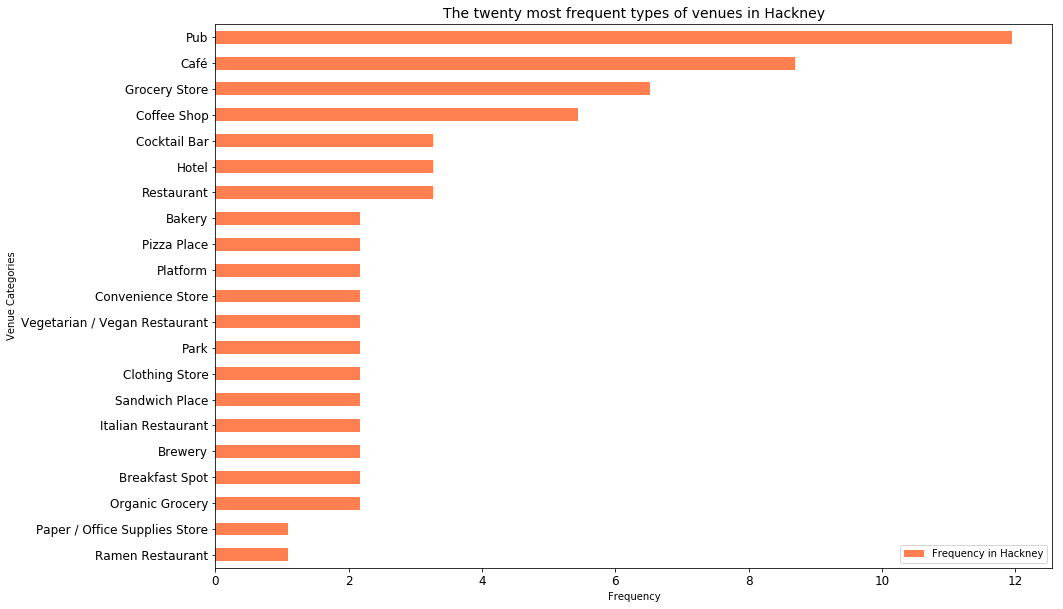

In [76]:
top20_Hackney=Hackney_grouped[0:21]
top20_Hackney.sort_values(by=['Frequency in Hackney'],ascending=True,inplace=True)
y_labels=top20_Hackney['Category']
ax=top20_Hackney.plot.barh(figsize=(15,10), fontsize=12, color='coral')
ax.set_title("The twenty most frequent types of venues in Hackney", fontsize=14)
ax.set_xlabel("Frequency")
ax.set_ylabel("Venue Categories")
ax.set_yticklabels(y_labels)
plt.show()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


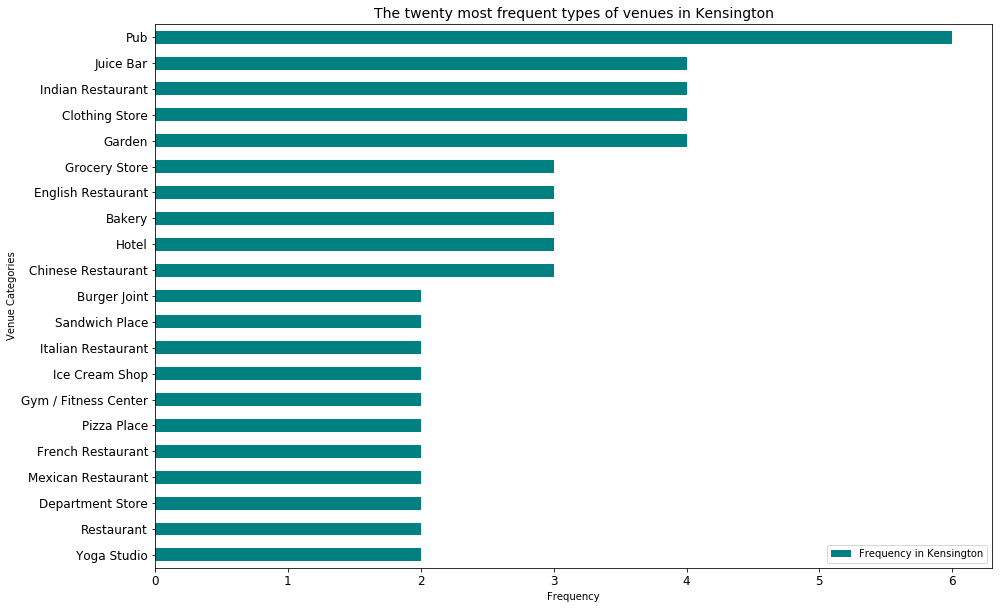

In [77]:
top20_Kensington=Kensington_grouped[0:21]
top20_Kensington.sort_values(by=['Frequency in Kensington'],ascending=True,inplace=True)
y_labels=top20_Kensington['Category']
ax=top20_Kensington.plot.barh(figsize=(15,10), fontsize=12, color='teal')
ax.set_title("The twenty most frequent types of venues in Kensington",fontsize=14)
ax.set_xlabel("Frequency")
ax.set_ylabel("Venue Categories")
ax.set_yticklabels(y_labels)
plt.show()

Judging by the bar charts, both areas look very appealing in terms of food and accommodation, with a massive presence of hotels, restaurants, bars and pubs among the top twenty types of venues. One can easily observe, however, that Kensington’s offer, except for restaurants and pubs, tilts a little towards daytime activities: among the most popular categories we find juice bars, gardens, clothing stores, bakeries, grocery stores and the like. On the other hand, the Hackney chart gives a sense of a slightly more entertaining neighborhood, one that promises a more exciting nightlife: observe the net prevalence of pubs, cafés, cocktail bars and restaurants over other categories, while performing art venues even make it in the top twenty. 

Now that we know the kinds of venues we are dealing with, let's visualize them on a Folium map (as blue circles). More importantly, let's observe how the cinemas are spatially distributed (the yellow circles) and how the venues are distributed around them in each neighborhood. The red circle marker represents the average of the cinemas' coordinates I used to query the Foursquare database. I will plot Kensington and Chelsea first, then Hackney.

In [78]:
Kensington_map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=14) # generate map centred around Ecco

# add the mean cinema coordinates as a red circle mark
folium.features.CircleMarker(
    [mean_latitude, mean_longitude],
    radius=10,
    popup='the center point between the Kensington Cinemas',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(Kensington_map)

# add the individual cinema coordinates as a yellow circle mark
for lat, lng, label in zip(Kensington_df['Venue Latitude'], Kensington_df['Venue Longitude'],Kensington_df['Venue']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=12,
        popup=label,
        fill=True,
        color='yellow',
        fill_color='yellow',
        fill_opacity=0.6
        ).add_to(Kensington_map)


# add popular spots to the map as blue circle markers
for lat, lng, label in zip(Kensington_filtered.lat, Kensington_filtered.lng, Kensington_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(Kensington_map)

Kensington_map

In [79]:
Hackney_map = folium.Map(location=[Hmean_latitude, Hmean_longitude], zoom_start=14) # generate map centred around Ecco


# add the mean coordinates as a red circle mark
folium.features.CircleMarker(
    [Hmean_latitude, Hmean_longitude],
    radius=10,
    popup='the center point between the chosen Hackney Cinemas',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(Hackney_map)

# add the individual cinema coordinates as a yellow circle mark
for lat, lng, label in zip(Hackney_df['Venue Latitude'], Hackney_df['Venue Longitude'],Hackney_df['Venue']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=12,
        popup=label,
        fill=True,
        color='yellow',
        fill_color='yellow',
        fill_opacity=0.6
        ).add_to(Hackney_map)

# add popular spots to the map as blue circle markers
for lat, lng, label in zip(Hackney_filtered.lat, Hackney_filtered.lng, Hackney_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(Hackney_map)

Hackney_map

## Results and Discussion <a name="results"></a>

From the previous steps, I gather that both boroughs look like feasible and attractive choices of location for the festival that the foundation is looking to organize. All the cinemas in both areas enjoy a great reputation, while the neighborhoods are lively and packed with places to stay, places to eat, and things to do.<br>
If I can make a recommendation, however, I would suggest the borough of Hackney as a first choice. While the borough of Kensington and Chelsea enjoys a solid reputation and some of its landmarks, such as Portobello Road, where one of the cinemas is situated, even hold a sentimental value for Londoners and tourists, Hackney, like of most of East London, has become in recent years the ‘it’ place to be and is now considered one of the trendiest places in London. I believe that this shows in the venue frequency bar charts above, where Hackney clearly demonstrated a stronger inclination for the hospitality business (except for hotels, where the two boroughs nearly tie).

I suggest Hackney also for another and, I think, more important reason. As we can seen in the Folium maps above, while the cinemas in Kensington are distributed along a straight line, making it rather tedious for the guests to go back and forth as they switch film programs during the day, Hackney‘s cinemas draw a trapezoid on the map, with two corners in trendy Dalston, two corners in Hackney Central and, in the middle, the heart of the district. As I see it, they form an enclosed, exclusive space dedicated to the festival and its guests, where they can move around freely, choose from the many venues available, get to know the neighborhood as they switch cinemas during the day and feel as if there were at center of something. I think the spatial distribution of the cinemas in Hackney is certainly more guest-oriented.

## Conclusion <a name="conclusion"></a>

This report was an effort to show that London can provide the right setting for the kind of event that the foundation wishes to export. Based on the notion that the festival should be organized within a single London borough, because I think that having a single interlocutor would simplify the process, I created a data frame in which the cinemas of London were grouped according to their borough; then, I transformed the boroughs into clusters to examine each area’s cinemas in more detail. The clustering process revealed that only two boroughs fit the basic requirements initially stated in the business problem of having three, possibly independent, cinemas within their borders: the borough of Kensington and Chelsea and the borough of Hackney. Both boroughs offer a great deal of options in terms of accommodation, food, and entertainment, with the difference that Kensington is a little more biased towards daytime activities, with little to offer in terms of nightlife, while Hackney’s offer covers the whole spectrum. For this reason, as well as for the spatial distribution of the cinemas in the area, which I consider to be more guest-oriented, I suggested that Hackney should be the foundation’s first choice of location. 

I trust that the research provides some useful insights on which the foundation can build further analyses, but there is much more work to be done on a number of fronts. The cinemas certainly need to be explored further, for instance in terms of number of screens, seats, staff, projection equipment and availability; the neighborhoods should definitely be explored further, as it would be a good idea to look for partners in hotel, restaurant and shop managers who may be interested in sponsoring the festival or may be willing to offer deals and discounts to the festival guests. However, the first step is, in my view, to approach the borough councils and get them involved from the very start in the festival's planning and decision making process, as the foundation will need an advisor, if not an ally, as it ventures into unknown territory.